In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

seed = 42
np.random.seed = seed

In [ ]:
import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

seed = 42
np.random.seed = seed

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

# Update the path to your dataset root directory
ROOT_PATH = '/content/drive/MyDrive/Sowmik Dataset/Planned_way/'

# List of subfolder names containing images
image_subfolders = ['Forest all processed file/Preprocessed forest',
                    'Forest all processed file/PP aug_forests',
                    'Park all processed data/Preprocessed park',
                    'Park all processed data/PP aug_parks',
                    'Residence all processed data/Preprocessed Residence',
                    'Residence all processed data/PP aug_residence'
                    ]

# List of corresponding subfolders containing masks
mask_subfolders = ['Forest all processed file/Preprocessed forest/bmask_forest',
                   'Forest all processed file/PP aug_forests/abmask_forests',
                   'Park all processed data/Preprocessed park/bmask_park',
                   'Park all processed data/PP aug_parks/abmask_park',
                   'Residence all processed data/Preprocessed Residence/bmask_residence',
                   'Residence all processed data/PP aug_residence/abmask_residence'
                   ]

X_data = []
Y_data = []

for image_subfolder, mask_subfolder in zip(image_subfolders, mask_subfolders):
    IMAGE_PATH = os.path.join(ROOT_PATH, image_subfolder)
    MASK_PATH = os.path.join(ROOT_PATH, mask_subfolder)

    # Get a list of image file names from the current image subfolder
    image_files = [file for file in os.listdir(IMAGE_PATH) if file.endswith('.jpg')]  # Update the file extension if needed

    for n, image_file in tqdm(enumerate(image_files), total=len(image_files)):
        img = imread(os.path.join(IMAGE_PATH, image_file))[:, :, :IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_data.append(img)

        mask_file = f'pp_{image_file[:-4]}_mask.jpg'
        mask = imread(os.path.join(MASK_PATH, mask_file))
        mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        Y_data.append(mask)

X_data = np.array(X_data, dtype=np.uint8)
Y_data = np.array(Y_data, dtype=np.bool)

print('X_data shape:', X_data.shape)
print('Y_data shape:', Y_data.shape)


100%|██████████| 260/260 [01:22<00:00,  3.16it/s]


X_data shape: (996, 256, 256, 3)
Y_data shape: (996, 256, 256, 1)


<ipython-input-7-8d451a2afee6>:60: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_data = np.array(Y_data, dtype=np.bool)


In [ ]:
# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data, test_size=0.1, random_state=seed)


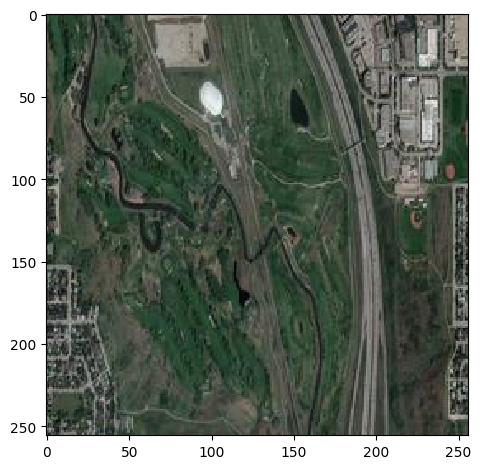

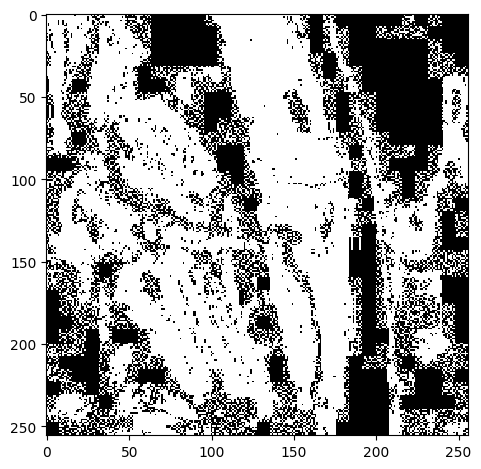

In [ ]:
import random
image_x = random.randint(0, len(image_files))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()


In [ ]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()

In [ ]:
# Model checkpoint callback
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_green_area.h5', verbose=1, save_best_only=True)


In [ ]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]


In [ ]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
51/51 [==============================] - 521s 10s/step - loss: 0.5453 - accuracy: 0.7245 - val_loss: 0.5015 - val_accuracy: 0.7949
Epoch 2/25
51/51 [==============================] - 539s 11s/step - loss: 0.4335 - accuracy: 0.8083 - val_loss: 0.3950 - val_accuracy: 0.8311
Epoch 3/25
51/51 [==============================] - 553s 11s/step - loss: 0.3783 - accuracy: 0.8337 - val_loss: 0.3494 - val_accuracy: 0.8430
Epoch 4/25
51/51 [==============================] - 571s 11s/step - loss: 0.3472 - accuracy: 0.8443 - val_loss: 0.3431 - val_accuracy: 0.8489
Epoch 5/25
51/51 [==============================] - 576s 11s/step - loss: 0.3406 - accuracy: 0.8461 - val_loss: 0.3241 - val_accuracy: 0.8525
Epoch 6/25
51/51 [==============================] - 534s 10s/step - loss: 0.3287 - accuracy: 0.8496 - val_loss: 0.3191 - val_accuracy: 0.8549
Epoch 7/25
51/51 [==============================] - 526s 10s/step - loss: 0.3195 - accuracy: 0.8517 - val_loss: 0.3089 - val_accuracy: 0.8571
Epoch 

In [ ]:
# Import necessary libraries
from sklearn.metrics import accuracy_score, f1_score

# Assuming you have loaded and preprocessed your data and trained your model
# ...

# Predict on the validation data
prediction = model.predict(X_val)

# Threshold the predicted probabilities to get binary masks
prediction_binary = (prediction > 0.5).astype(np.uint8)
Y_val_binary = (Y_val > 0.5).astype(np.uint8)

# Calculate accuracy
accuracy = accuracy_score(Y_val_binary.flatten(), prediction_binary.flatten())

# Print the accuracy
print(f"Test Accuracy: {accuracy*100}%")

f1score = f1_score(Y_val_binary.flatten(), prediction_binary.flatten())

# Print the F1-score
print(f"F1-Score: {f1score}")

from sklearn.metrics import precision_score

# Calculate precision
precision = precision_score(Y_val_binary.flatten(), prediction_binary.flatten())

print(f"Precision: {precision}")


4/4 [==============================] - 14s 3s/step
Test Accuracy: 87.34225463867188%
F1-Score: 0.7502229673537254
Precision: 0.8696648916712973


4/4 [==============================] - 15s 4s/step


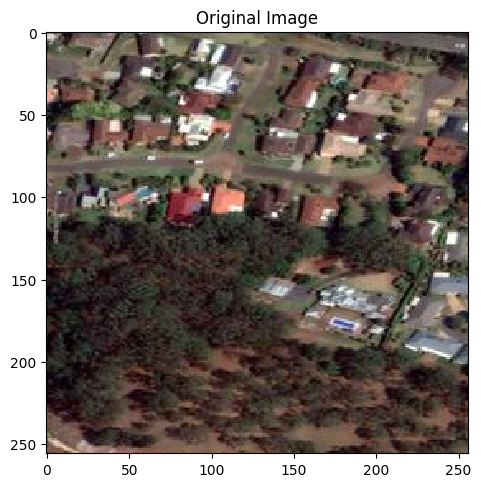

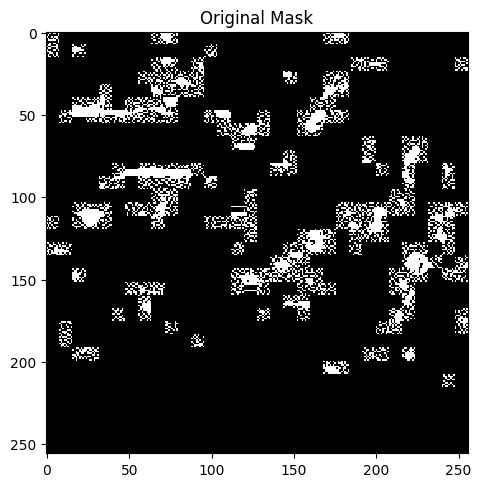

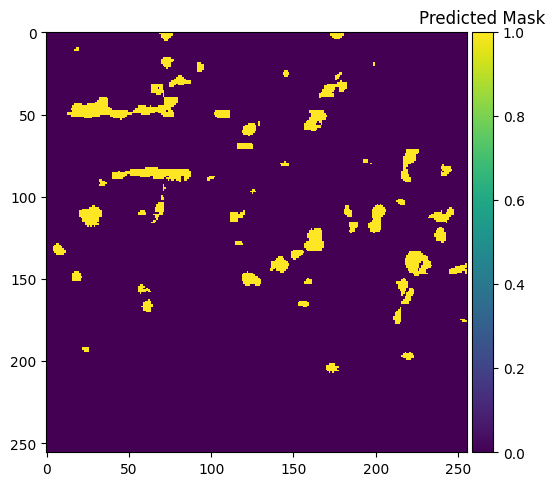

In [ ]:
# Predict on the validation set
preds_val = model.predict(X_val, verbose=1)

# Threshold predictions (convert to binary)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

# Perform a sanity check on some random validation samples
ix = np.random.randint(0, len(X_val))
imshow(X_val[ix])
plt.title("Original Image")
plt.show()
imshow(np.squeeze(Y_val[ix]))
plt.title("Original Mask")
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.title("Predicted Mask")
plt.show()

In [ ]:
new_model_name = 'unet_customdataset.h5'
model.save('/content/drive/My Drive/' + new_model_name)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


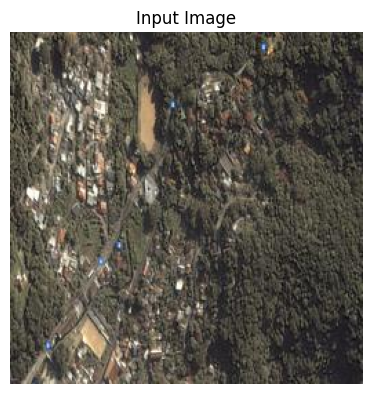

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load the image you want to predict (replace 'your_image.jpg' with the path to your image)
image_path = '/content/drive/MyDrive/Sowmik Dataset/Planned_way/Forest all processed file/Preprocessed forest/Alto da Boa Vista, Brazil 2000.jpg'
input_image = cv2.imread(image_path)  # Load the image using OpenCV

# Ensure the image has the correct data type (CV_8U)
input_image = input_image.astype(np.uint8)

# Convert the input image from BGR to RGB color space for displaying with matplotlib
input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

# Display the input image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image_rgb)
plt.title('Input Image')
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 269ms/step


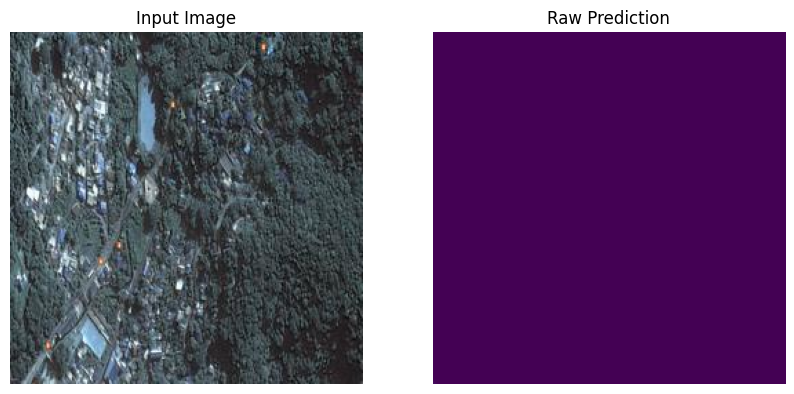

In [ ]:
# Assuming you have your model loaded and named 'model'
# Make sure 'input_image' contains the loaded image

# Preprocess the input image (resize it to match the model's input size and normalize)
input_image = cv2.resize(input_image, (IMG_WIDTH, IMG_HEIGHT))
#input_image = input_image / 255.0  # Normalize pixel values to the range [0, 1]

# Make a prediction using the model
prediction = model.predict(np.expand_dims(input_image, axis=0))

# Visualize the prediction
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(prediction[0, :, :, 0], cmap='viridis', vmin=0, vmax=1)  # Display the raw prediction
plt.title('Raw Prediction')
plt.axis('off')

plt.show()
